In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

from math import sqrt, pow


import gym

import pandas as pd
import numpy as np

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../'))

from lcs.agents import EnvironmentAdapter
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def print_cl(cl):
    action = None
    marked = ''
    
    if cl.action == 0:
        action = 'L'
    if cl.action == 1:
        action = 'R'
    
    if cl.is_marked():
        marked = '(*)'
    
    return (f"{cl.condition} - {action} - {cl.effect} [fit: {cl.fitness:.3f}, r: {cl.r:.2f}, ir: {cl.ir:.2f}] {marked}")

## The first step is interact randomly with the environment to get maximum values for observations (later discretization)

In [3]:
env = gym.make('CartPole-v0')

observations = []

for _ in range(10_000):
    env.reset()
    done = False
    while not done:
        obs, reward, done, _ = env.step(env.action_space.sample())
        observations.append(obs)

env.close()

df = pd.DataFrame(
    observations,
    columns=['cart_position','cart_velocity','pole_angle','pole_tip_velocity'])

len(df)

222920

In [4]:
df.describe().loc[['min','max']]

,cart_position,cart_velocity,pole_angle,pole_tip_velocity
min,-1.886550,-3.010702,-0.263261,-3.317738
max,1.920572,2.807046,0.269485,3.380160


# Creating bins

In [5]:
# the loop-up table approach probably would be faster

class Mapper:
    def __init__(self, bins, x1, x2):
        self.bins = bins
        self.x1 = x1
        self.x2 = x2
        self.step = sqrt(pow(x2-x1, 2)) / bins
    
    def to_bin(self, x):
        for i in range(self.bins):
            start = self.x1 + i * self.step
            end = start + self.step
            if start <= x <= end:
                return str(i)
            
        raise ValueError('Illegal value passed' + str(x))
    
    def to_val(self, b):
        return self.x1 + int(b) * self.step

In [6]:
m = Mapper(10, -4.2, 4.2)

print(m.to_bin(-1.6))
print(m.to_val('10'))

3
4.2


# Create the environment adapter

In [7]:
class CartPoleAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        bins = 10
        mappers = [
            Mapper(bins, -4.8, 4.8),
            Mapper(bins, -3.5, 3.5),
            Mapper(bins, -0.27, 0.27),
            Mapper(bins, -3.7, 3.7)
        ]
        return tuple(mapper.to_bin(obs) for obs, mapper in zip(phenotype, mappers))

In [8]:
ad = CartPoleAdapter()
ad.to_genotype([2, 2, 0, 3])

('7', '7', '4', '9')

# ACS2 Configuration

In [9]:
cfg = Configuration(
            classifier_length=4,
            number_of_possible_actions=2,
            epsilon=1.0,
            beta=0.05,
            gamma=0.95,
            theta_exp=50,
            theta_ga=50,
            do_ga=True,
            mu=0.03,
            u_max=4,
            metrics_trial_frequency=5,
            environment_adapter=CartPoleAdapter)

In [10]:
env = gym.make('CartPole-v0')

explorer = ACS2(cfg)
population_explore, metrics_explore = explorer.explore(env, 5_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 15, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 13, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 19, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 78, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 400, 'steps_in_trial': 22, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 500, 'steps_in_trial': 40, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 28, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 700, 'steps_in_trial': 23, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 800, 'steps_in_trial': 28, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 900, 'steps_in_trial': 22, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 1000, 'steps_in_trial': 12, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 1100, 'steps_in_trial': 23, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 1200, 'steps_in_trial': 17, 'reward': 1.0}
INFO:lcs.agents.Agent:{'trial': 1300,

In [11]:
print(len(population_explore))

2233


In [12]:
for cl in sorted(population_explore, key=lambda cl: -cl.fitness)[:30]:
    print(print_cl(cl))

5555 - R - ###4 [fit: 2.758, r: 2.81, ir: 1.00] 
5454 - L - ###5 [fit: 2.687, r: 2.77, ir: 1.00] 
5444 - L - ###5 [fit: 2.682, r: 2.72, ir: 1.00] 
5545 - L - #4## [fit: 2.651, r: 2.83, ir: 1.00] 
4545 - L - #4## [fit: 2.650, r: 2.68, ir: 1.00] 
4545 - R - ###4 [fit: 2.621, r: 2.64, ir: 1.00] 
5454 - R - #5## [fit: 2.616, r: 2.66, ir: 1.00] 
5555 - L - #4## [fit: 2.606, r: 2.72, ir: 1.00] 
4454 - R - #5## [fit: 2.566, r: 2.62, ir: 1.00] 
4555 - L - #4## [fit: 2.559, r: 2.76, ir: 1.00] 
4454 - L - ###5 [fit: 2.549, r: 2.68, ir: 1.00] 
5545 - R - ###4 [fit: 2.545, r: 2.60, ir: 1.00] 
5444 - R - #5## [fit: 2.529, r: 2.56, ir: 1.00] 
5434 - L - ###5 [fit: 2.454, r: 2.52, ir: 1.00] 
4555 - R - ###4 [fit: 2.437, r: 2.62, ir: 1.00] 
4444 - L - ###5 [fit: 2.432, r: 2.58, ir: 1.00] 
4444 - R - #5## [fit: 2.416, r: 2.70, ir: 1.00] 
5545 - L - #45# [fit: 2.384, r: 2.83, ir: 1.00] 
4565 - R - ###4 [fit: 2.373, r: 2.78, ir: 1.00] 
5554 - L - #4#5 [fit: 2.360, r: 2.92, ir: 1.00] 
4334 - R - #4## [fit

Avg steps 28.804


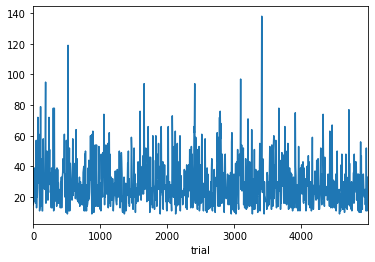

In [13]:
explore_df = pd.DataFrame(metrics_explore)
explore_df.set_index('trial', inplace=True)
print(f"Avg steps {explore_df['steps_in_trial'].mean()}")
explore_df['steps_in_trial'].plot();

In [14]:
exploiter = ACS2(cfg, population_explore)
population_exploit, metrics_exploit = explorer.exploit(env, 100)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 187, 'reward': 1.0}


Avg steps 142.0


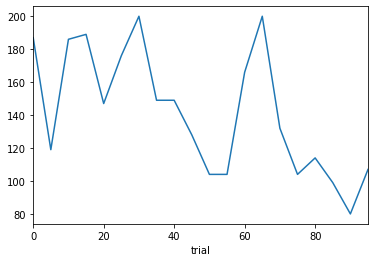

In [15]:
exploit_df = pd.DataFrame(metrics_exploit)
exploit_df.set_index('trial', inplace=True)
print(f"Avg steps {exploit_df['steps_in_trial'].mean()}")
exploit_df['steps_in_trial'].plot();